In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.append('..')

This notebook is a guide for the reconstruction analysis of the library of the project "". :)

Météo-France, CNRS, CNRM, Centre d’Etudes de la Neige \
Léo Catteau, Spring 2025

### Contents:
* [Spatial aggregation of error](#first-bullet)
* [Temporal aggregation of error](#second-bullet)
* [Latent space analysis](#third-bullet)

In [2]:
from data_provider.data_provider import DataProvider
from models.linear import linear
from models.GRIN import GRINet
from trainer.Filler import Filler

from types import SimpleNamespace

from evaluation.evaluation import statistical_comparison, autocorrelation, seasonal_analysis

/Users/leocatteau/opt/anaconda3/lib/python3.9/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 11.0.0. Please consider upgrading.
  warnings.warn(
/Users/leocatteau/opt/anaconda3/lib/python3.9/site-packages/umap/plot.py:203: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit(nopython=False)


In [3]:
data_kwargs = SimpleNamespace()
data_kwargs.data = 'bdclim_clean'
data_kwargs.dataset = 'WindowHorizonDataset'
data_kwargs.root_path = '../../datasets/'
data_kwargs.data_path = 'bdclim_safran_2023-2024.nc'
data_kwargs.has_predictors = False
data_kwargs.scaler = None
data_kwargs.batch_size = 1
data_kwargs.mask_length = 24*7*10
data_kwargs.mask_proba = 0.5
data_kwargs.window = 24*7*1
data_kwargs.horizon = 0

data_provider = DataProvider(data_kwargs)
clean_data = data_provider.dataset.data
corrupted_data = data_provider.dataset.corrupted_data
mask = data_provider.dataset.mask
eval_mask = data_provider.dataset.eval_mask
dataloader = data_provider.dataloader()
adjacency_matrix = torch.FloatTensor(data_provider.data.umap_adjacency(threshold=0.1, verbose=False)).to('cuda:0' if torch.cuda.is_available() else 'cpu')


model_kwargs = dict(adj=adjacency_matrix, d_in=1) # GRINet
# model_kwargs = dict(seq_dim=data_provider.data.n_nodes) # linear model
filler_kwargs = SimpleNamespace()
filler_kwargs.lr = 1e-4
filler_kwargs.epochs = 100
filler_kwargs.keep_proba = 1-data_kwargs.mask_proba

filler = Filler(GRINet, model_kwargs, filler_kwargs)
filler.load_model('../trained_models/GRINet.pt')

device:  cpu


/Users/leocatteau/Desktop/EPFL/Météo-France/code/Meteo-France/notebook_guides/../data_provider/data_preparation.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.data = torch.tensor(self.data)


device:  cpu


In [4]:
corrupted_data, reconstructed_data = filler.reconstruct_from_loader(dataloader)

torch.Size([8761, 639])
torch.Size([8761, 639])


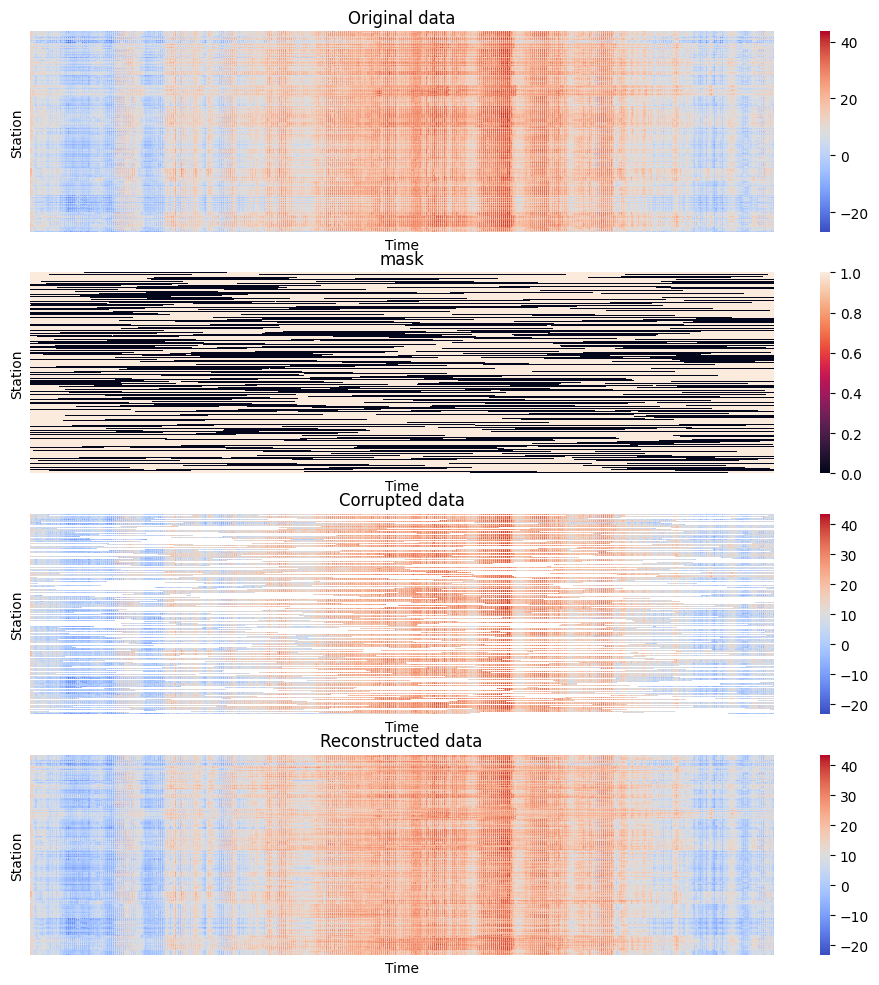

In [5]:
print(reconstructed_data.shape)
print(corrupted_data.shape)

fig, ax = plt.subplots(4, 1, figsize=(12, 12))
sns.heatmap(clean_data.T, xticklabels=False, yticklabels=False, cmap="coolwarm", ax=ax[0])
ax[0].set_title("Original data")
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Station")
sns.heatmap(mask.T, xticklabels=False, yticklabels=False, ax=ax[1])
ax[1].set_title("mask")
ax[1].set_xlabel("Time")
ax[1].set_ylabel("Station")
sns.heatmap(corrupted_data.T, xticklabels=False, yticklabels=False, cmap="coolwarm", ax=ax[2])
ax[2].set_title("Corrupted data")
ax[2].set_xlabel("Time")
ax[2].set_ylabel("Station")
sns.heatmap(reconstructed_data.T, xticklabels=False, yticklabels=False, cmap="coolwarm", ax=ax[3])
ax[3].set_title("Reconstructed data")
ax[3].set_xlabel("Time")
ax[3].set_ylabel("Station")
plt.show()

In [6]:
stats = statistical_comparison(reconstructed_data, clean_data)

,Metric,Original Data,Imputed Data (GRIN)
0,count,8761.000000,8761.000000
1,mean,15.376418,15.995720
2,std,5.868609,6.191998
3,min,-1.800000,-1.800000
4,25%,11.558479,11.800000
5,50%,15.700000,16.200001
6,75%,19.400000,20.600000
7,max,34.099998,34.799999


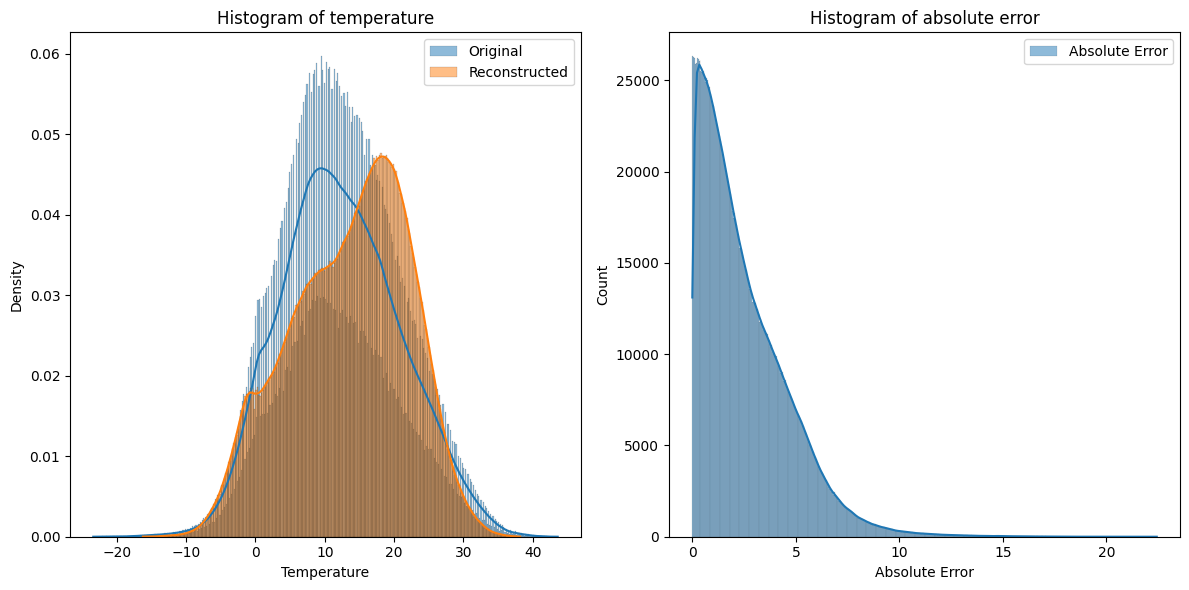

In [10]:
original_station_temp = reconstructed_data[np.where(mask)]
reconstructed_station_temp = reconstructed_data[np.where(~mask)]
absolute_error = np.abs(reconstructed_data - clean_data)[np.where(~eval_mask)]

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
sns.histplot(original_station_temp, label='Original', kde=True, stat="density", ax=ax[0])
sns.histplot(reconstructed_station_temp, label='Reconstructed', kde=True, stat="density", ax=ax[0])
# ax[0].set_yscale('log')
ax[0].set_title("Histogram of temperature")
ax[0].set_xlabel("Temperature")
ax[0].set_ylabel("Density")
ax[0].legend()
sns.histplot(absolute_error, label='Absolute Error', kde=True, ax=ax[1])
# ax[1].set_yscale('log')
ax[1].set_title("Histogram of absolute error")
ax[1].set_xlabel("Absolute Error")
ax[1].set_ylabel("Count")
ax[1].legend()
plt.tight_layout()
plt.show()

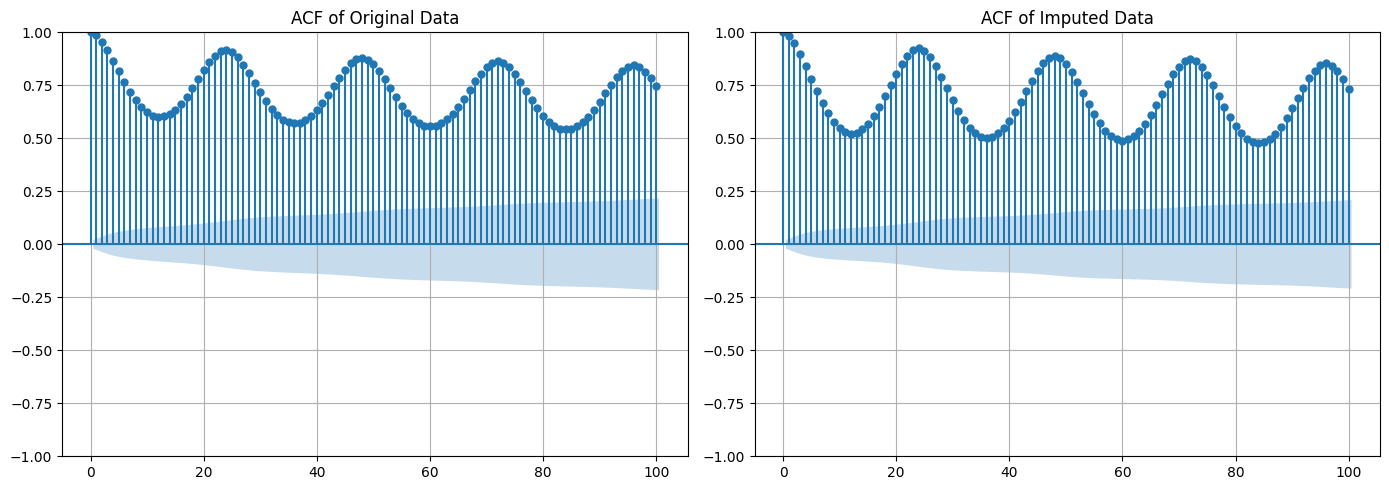

In [11]:
autocorrelation(reconstructed_data, clean_data)

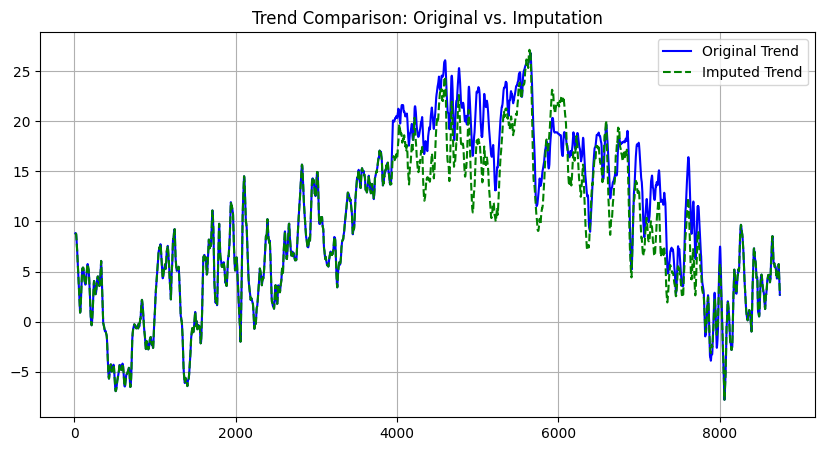

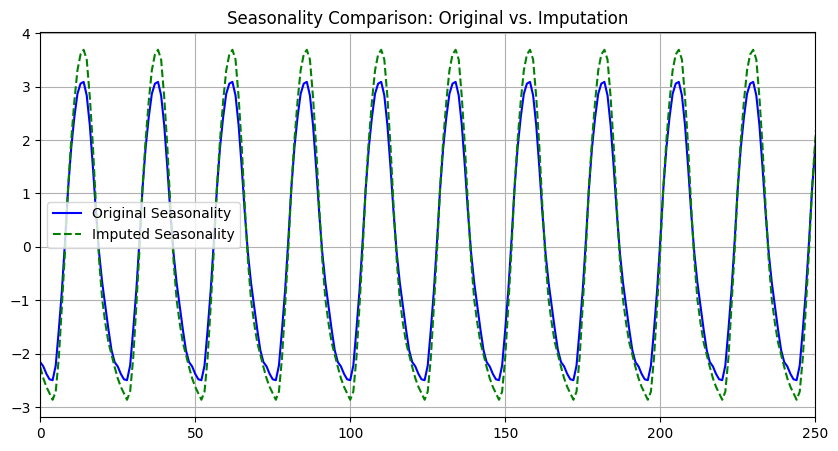

In [12]:
seasonal_analysis(reconstructed_data, clean_data)

### Spatial aggregation of error <a class="anchor" id="first-bullet"></a>

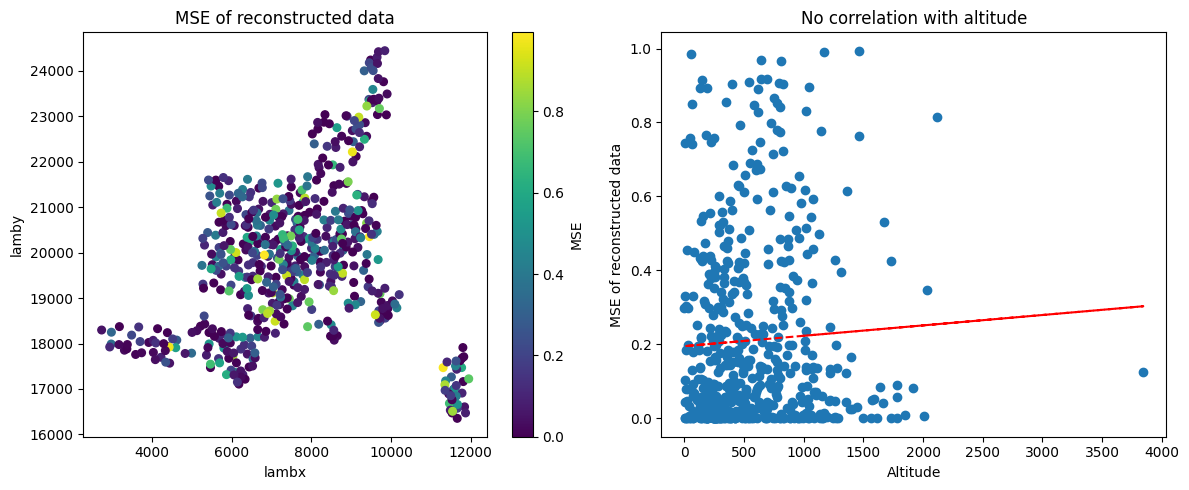

In [13]:
spatial_MSE = torch.square(torch.mean(reconstructed_data - clean_data, dim=0))
coords = [data_provider.data.predictors['lambx'].values, data_provider.data.predictors['lamby'].values]
altitude = data_provider.data.predictors['ZS'].values

treshold = 1
loc_aberrations = np.where(spatial_MSE > treshold)
spatial_MSE = spatial_MSE[np.where(spatial_MSE<treshold)]
coords = [coords[0][np.where(spatial_MSE<treshold)], coords[1][np.where(spatial_MSE<treshold)]]
altitude = altitude[np.where(spatial_MSE<treshold)]

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].scatter(coords[0], coords[1], c=spatial_MSE, cmap='viridis', s=30)
plt.colorbar(ax[0].collections[0], ax=ax[0], label='MSE')
ax[0].set_title('MSE of reconstructed data')
ax[0].set_xlabel('lambx')
ax[0].set_ylabel('lamby')
ax[1].scatter(altitude, spatial_MSE)
# linear fit 
z = np.polyfit(altitude, spatial_MSE, 1)
p = np.poly1d(z)
ax[1].plot(altitude, p(altitude), "r--", label='Linear fit')
ax[1].set_xlabel('Altitude')
ax[1].set_ylabel('MSE of reconstructed data')
ax[1].set_title('No correlation with altitude')
plt.tight_layout()
plt.show()

In [14]:
import seaborn as sns
from io import BytesIO
from PIL import Image
import cv2
from tqdm import tqdm

In [15]:
coords = [data_provider.data.predictors['lambx'].values, data_provider.data.predictors['lamby'].values]

frames = []
for i in tqdm(range(100)):
    data = clean_data[i]
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.scatter(coords[0], coords[1], c=data, cmap='coolwarm', s=30, vmin=-10, vmax=20)
    plt.colorbar(ax.collections[0], ax=ax, label='Temperature')
    ax.set_xlabel("lambx")
    ax.set_ylabel("lamby")
    buf = BytesIO()
    plt.savefig(buf, format='png')
    plt.close(fig)
    buf.seek(0)
    img = Image.open(buf)
    frame = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    frames.append(frame)

# save video
height, width, _ = frames[0].shape
video = cv2.VideoWriter('spatial_temperature.mp4', cv2.VideoWriter_fourcc(*'mp4v'), 10, (width, height))
for frame in frames:
    video.write(frame)
video.release()


absolute_error = np.abs(reconstructed_data - clean_data)
frames = []
for i in tqdm(range(100)):
    data = absolute_error[i]
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.scatter(coords[0], coords[1], c=data, cmap='RdYlGn_r', s=30, vmin=0, vmax=8)
    plt.colorbar(ax.collections[0], ax=ax, label='absolute error')
    ax.set_xlabel("lambx")
    ax.set_ylabel("lamby")
    buf = BytesIO()
    plt.savefig(buf, format='png')
    plt.close(fig)
    buf.seek(0)
    img = Image.open(buf)
    frame = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    frames.append(frame)

# save video
height, width, _ = frames[0].shape
video = cv2.VideoWriter('spatial_error.mp4', cv2.VideoWriter_fourcc(*'mp4v'), 10, (width, height))
for frame in frames:
    video.write(frame)
video.release()

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:12<00:00,  8.11it/s]


### Temporal aggregation of error <a class="anchor" id="second-bullet"></a>

In [21]:
from data_provider.data_provider import DataProvider
from models.linear import linear
from models.MLP import MLP
from trainer.Filler import Filler

from types import SimpleNamespace

In [22]:
data_kwargs = SimpleNamespace()
data_kwargs.data = 'bdclim_clean'
data_kwargs.dataset = 'PatchMaskDataset'
data_kwargs.root_path = '../../datasets/'
data_kwargs.data_path = 'bdclim_safran_2023-2024.nc'
data_kwargs.has_predictors = False
data_kwargs.scaler = None
data_kwargs.batch_size = 50
data_kwargs.mask_length = 24*7*10
data_kwargs.mask_proba = 0.9
data_kwargs.treshold_time = 0.25

data_provider = DataProvider(data_kwargs)
clean_data = data_provider.dataset.data
corrupted_data = data_provider.dataset.corrupted_data
mask = data_provider.dataset.mask
dataloader = data_provider.dataloader()

device:  cpu


In [18]:
model_kwargs = dict(seq_dim=data_provider.data.n_nodes)
filler_kwargs = SimpleNamespace()
filler_kwargs.lr = 1e-4
filler_kwargs.epochs = 100
filler_kwargs.keep_proba = 1-data_kwargs.mask_proba
filler = Filler(linear, model_kwargs, filler_kwargs)
filler.load_model('../trained_models/linear.pt')
linear_reconstructed_data = filler.reconstruct(corrupted_data, mask)

model_kwargs = dict(seq_dim=data_provider.data.n_nodes, hidden_dim=2*data_provider.data.n_nodes)
filler_kwargs = SimpleNamespace()
filler_kwargs.lr = 1e-4
filler_kwargs.epochs = 100
filler_kwargs.keep_proba = 1-data_kwargs.mask_proba
filler = Filler(MLP, model_kwargs, filler_kwargs)
filler.load_model('../trained_models/MLP.pt')
MLP_reconstructed_data = filler.reconstruct(corrupted_data, mask)

model_kwargs = dict(seq_dim=data_provider.data.n_nodes, hidden_dim=int(0.25*data_provider.data.n_nodes))
filler_kwargs = SimpleNamespace()
filler_kwargs.lr = 1e-4
filler_kwargs.epochs = 100
filler_kwargs.keep_proba = 1-data_kwargs.mask_proba
filler = Filler(MLP, model_kwargs, filler_kwargs)
filler.load_model('../trained_models/autoencoder.pt')
autoencoder_reconstructed_data = filler.reconstruct(corrupted_data, mask)

device:  cpu


RuntimeError: Error(s) in loading state_dict for linear:
	size mismatch for model.0.weight: copying a param with shape torch.Size([1654, 1654]) from checkpoint, the shape in current model is torch.Size([639, 639]).
	size mismatch for model.0.bias: copying a param with shape torch.Size([1654]) from checkpoint, the shape in current model is torch.Size([639]).

In [ ]:

model_kwargs = dict(adj=adjacency_matrix, d_in=1) # GRINet
# model_kwargs = dict(seq_dim=data_provider.data.n_nodes) # linear model
filler_kwargs = SimpleNamespace()
filler_kwargs.lr = 1e-4
filler_kwargs.epochs = 100
filler_kwargs.keep_proba = 1-data_kwargs.mask_proba

filler = Filler(GRINet, model_kwargs, filler_kwargs)
filler.load_model('../trained_models/GRINet.pt')
GRINet_reconstructed_data = filler.reconstruct(corrupted_data, mask)

device:  cpu


NameError: name 'linear_reconstructed_data' is not defined

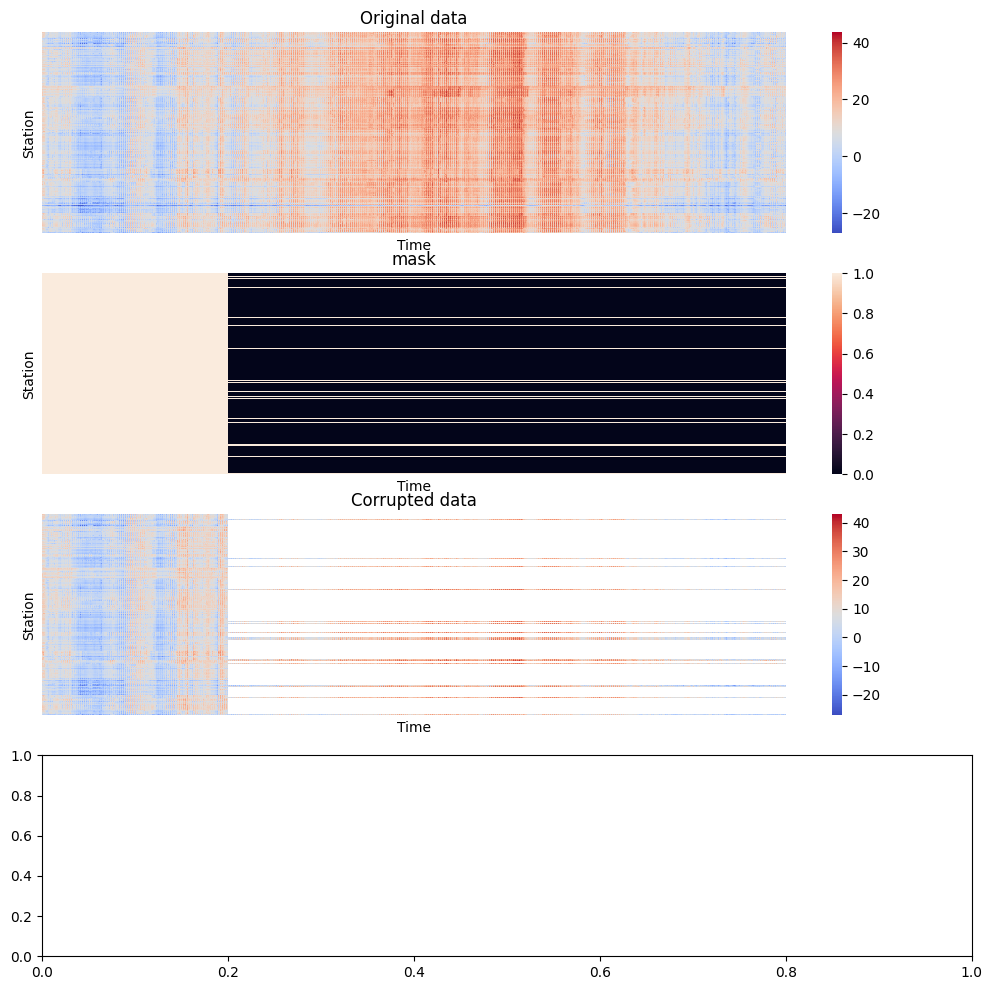

In [ ]:
fig, ax = plt.subplots(4, 1, figsize=(12, 12))
sns.heatmap(clean_data.T, xticklabels=False, yticklabels=False, cmap="coolwarm", ax=ax[0])
ax[0].set_title("Original data")
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Station")
sns.heatmap(mask.T, xticklabels=False, yticklabels=False, ax=ax[1])
ax[1].set_title("mask")
ax[1].set_xlabel("Time")
ax[1].set_ylabel("Station")
sns.heatmap(corrupted_data.T, xticklabels=False, yticklabels=False, cmap="coolwarm", ax=ax[2])
ax[2].set_title("Corrupted data")
ax[2].set_xlabel("Time")
ax[2].set_ylabel("Station")
sns.heatmap(GRINet_reconstructed_data.T, xticklabels=False, yticklabels=False, cmap="coolwarm", ax=ax[3])
ax[3].set_title("Reconstructed data")
ax[3].set_xlabel("Time")
ax[3].set_ylabel("Station")
plt.show()

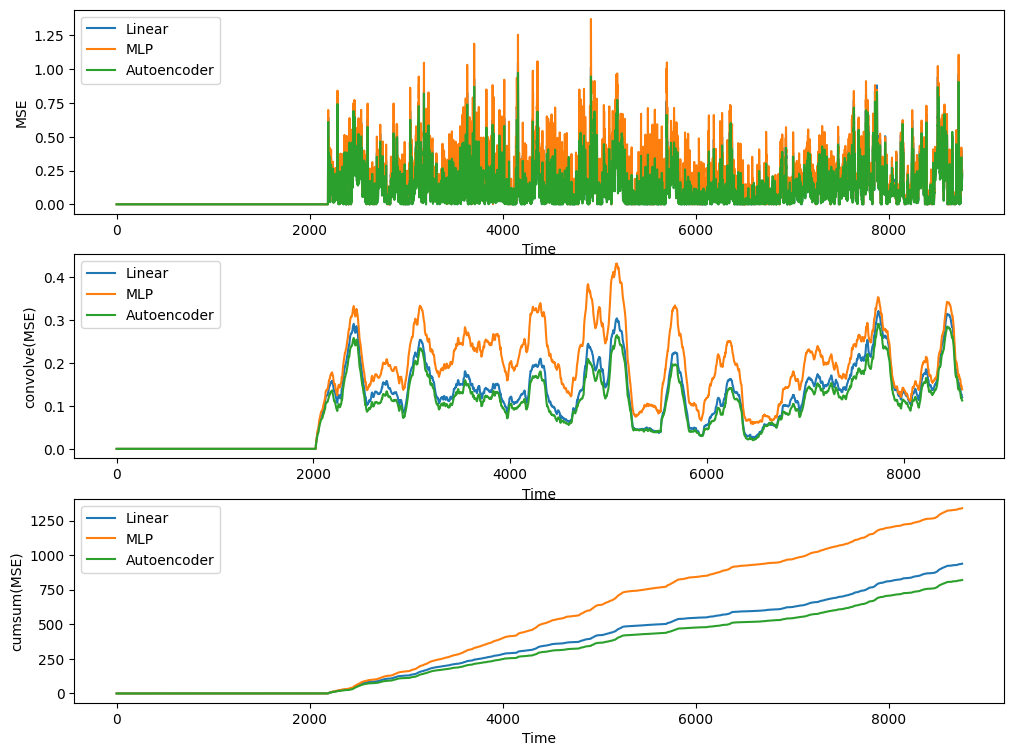

In [ ]:
linear_temporal_MSE = torch.square(torch.mean(linear_reconstructed_data - clean_data, axis=1))
MLP_temporal_MSE = torch.square(torch.mean(MLP_reconstructed_data - clean_data, axis=1))
autoencoder_temporal_MSE = torch.square(torch.mean(autoencoder_reconstructed_data - clean_data, axis=1))

window_size = 24*7
fig, ax = plt.subplots(3, 1, figsize=(12, 9))
ax[0].plot(linear_temporal_MSE, label='Linear')
ax[0].plot(MLP_temporal_MSE, label='MLP')
ax[0].plot(autoencoder_temporal_MSE, label='Autoencoder')
ax[0].set_xlabel('Time')
ax[0].set_ylabel('MSE')
ax[0].legend()
ax[1].plot(np.convolve(linear_temporal_MSE, np.ones(window_size)/window_size, mode='valid'), label='Linear')
ax[1].plot(np.convolve(MLP_temporal_MSE, np.ones(window_size)/window_size, mode='valid'), label='MLP')
ax[1].plot(np.convolve(autoencoder_temporal_MSE, np.ones(window_size)/window_size, mode='valid'), label='Autoencoder')
ax[1].set_xlabel('Time')
ax[1].set_ylabel('convolve(MSE)')
ax[1].legend()
ax[2].plot(np.cumsum(linear_temporal_MSE), label='Linear')
ax[2].plot(np.cumsum(MLP_temporal_MSE), label='MLP')
ax[2].plot(np.cumsum(autoencoder_temporal_MSE), label='Autoencoder')
ax[2].set_xlabel('Time')
ax[2].set_ylabel('cumsum(MSE)')
ax[2].legend()
plt.show()

### Latent space analysis <a class="anchor" id="third-bullet"></a>

In [ ]:
from data_provider.data_provider import DataProvider
from models.linear import linear
from trainer.Filler import Filler

from types import SimpleNamespace

/Users/leocatteau/opt/anaconda3/lib/python3.9/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 11.0.0. Please consider upgrading.
  warnings.warn(
/Users/leocatteau/opt/anaconda3/lib/python3.9/site-packages/umap/plot.py:203: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit(nopython=False)


In [3]:
data_kwargs = SimpleNamespace()
data_kwargs.data = 'bdclim_clean'
data_kwargs.dataset = 'WindowHorizonDataset'
data_kwargs.root_path = '../../datasets/'
data_kwargs.data_path = 'bdclim_safran_2023-2024.nc'
data_kwargs.has_predictors = False
data_kwargs.scaler = None
data_kwargs.batch_size = 50
data_kwargs.mask_length = 24*7*3
data_kwargs.mask_proba = 0.5
data_kwargs.window = 24
data_kwargs.horizon = 0

data_provider = DataProvider(data_kwargs)
train_dataloader = data_provider.train_dataloader()
corrupted_data = data_provider.dataset.data
mask = data_provider.dataset.mask

model_kwargs = dict(seq_dim=data_provider.data.n_nodes)
filler_kwargs = SimpleNamespace()
filler_kwargs.lr = 1e-4
filler_kwargs.epochs = 10
filler_kwargs.keep_proba = 1-data_kwargs.mask_proba

filler = Filler(linear, model_kwargs, filler_kwargs)

device:  cpu
device:  cpu


/Users/leocatteau/Desktop/EPFL/Météo-France/code/Meteo-France/notebook_guides/../data_provider/data_preparation.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.data = torch.tensor(self.data)


In [4]:
train_loss = filler.latent_training(train_dataloader=train_dataloader, data=corrupted_data, mask=mask)

start mini training for latent space analysis
Epoch 1/10, Loss: 60.40187836, time: 0.38s
Epoch 2/10, Loss: 35.96649933, time: 5.53s
Epoch 3/10, Loss: 22.12943172, time: 10.66s
Epoch 4/10, Loss: 15.35142326, time: 15.58s
Epoch 5/10, Loss: 12.46610284, time: 20.56s
Epoch 6/10, Loss: 11.25365233, time: 25.56s
Epoch 7/10, Loss: 10.46368456, time: 30.72s
Epoch 8/10, Loss: 10.03655553, time: 35.86s
Epoch 9/10, Loss: 9.53004146, time: 41.08s
Epoch 10/10, Loss: 9.18398070, time: 46.70s


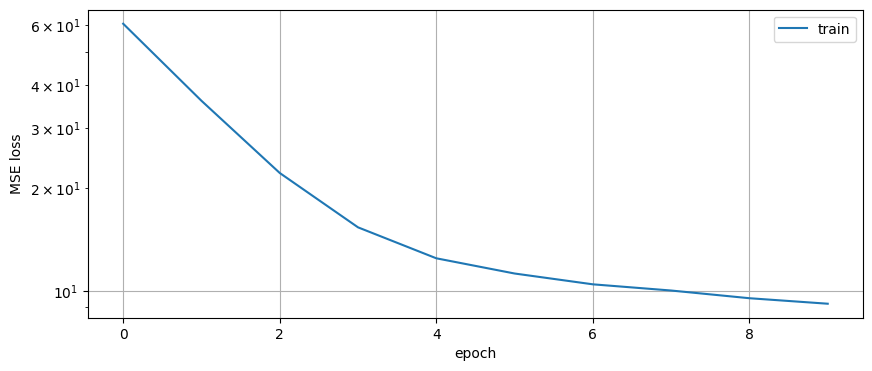

In [5]:
plt.figure(figsize=(10, 4))
plt.plot(train_loss, label='train')
plt.yscale('log')
plt.xlabel('epoch')
plt.ylabel('MSE loss')
plt.grid()
plt.legend()
plt.show()